Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Analisis de Churn para empresa de e-commerce

## Objetivo:

¿Cuántas personas llenan el carrito de la compra de un e-commerce y se van sin comprar nada? ¿Por qué es importante conocer esta métrica? ¿Cómo conseguir que compren los artículos en los que se habían interesado?

La tasa de abandono de los carritos, también conocida como Churn Rate, es uno de los datos más importantes en el análisis de un e-commerce, ya que nos informa del porcentaje de personas que se interesan por alguno de nuestros productos, pero finalmente no realiza ninguna conversión.
Para calcularlo matemáticamente debemos poner en marcha la siguiente métrica

Tasa de abandono del carrito = (Número de visitas que han añadido al menos un producto al carrito y no han comprado / Total de visitas que han añadido al menos un producto al carrito) x 100

## Lectura del dataset

In [2]:
df = pd.read_parquet('data-ecomm-10-19-smallsampled.parquet', engine='pyarrow')

In [17]:
df = pd.read_parquet('/content/drive/MyDrive/Diplomatura Data Science/datasets/data-ecomm-10-19-smallsampled.parquet', engine='pyarrow')

## Recolección de datos y primer análisis

In [3]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
39054315,2019-10-29 07:06:41 UTC,view,1004767,2053013555631882655,electronics.smartphone,samsung,243.220,564343135,76be743b-f5cd-47a2-82eb-b489597df6ba
2640418,2019-10-03 06:05:30 UTC,view,26020177,2053013562644759347,None,None,9.050,529412421,0ee743f2-1a41-4e6f-8d8e-cd38135032a0
24303444,2019-10-18 14:21:55 UTC,view,1307059,2053013558920217191,computers.notebook,apple,1569.920,549727626,022640cb-f45a-4e76-9ade-3eeec65d7837
16337102,2019-10-13 08:46:22 UTC,view,12709948,2053013553559896355,None,triangle,36.940,550305198,56ef2383-4c9d-4475-adcd-d4eeb4205fde
41227753,2019-10-31 02:05:01 UTC,view,1005160,2053013555631882655,electronics.smartphone,xiaomi,212.120,535374900,a4ee5bfa-3824-4f66-87fb-0d0ae358f307


In [13]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})

In [17]:
print('Proporción de tipo de actividad realizada en la página:')
df['event_type'].value_counts(normalize=True)*100

Proporción de tipo de actividad realizada en la página:


view       92.131
purchase    3.971
cart        3.898
Name: event_type, dtype: float64

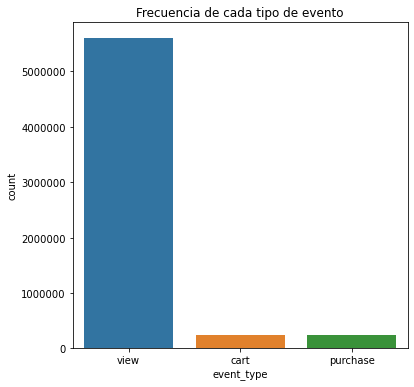

In [8]:
fig, ax = plt.subplots(figsize = (6, 6))
sns.set_context("notebook")
sns.countplot(x="event_type", data=df)
ax.set_title('Frecuencia de cada tipo de evento')
plt.ticklabel_format(style='plain', axis='y',useOffset=False)


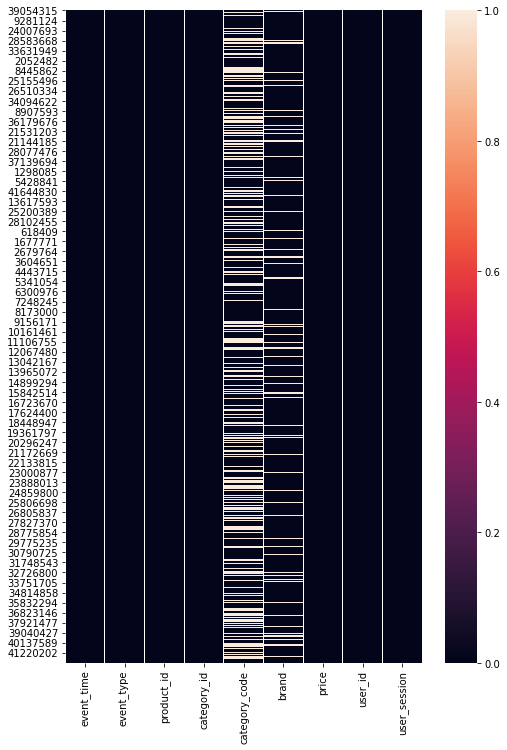

In [ ]:
fig, ax = plt.subplots(figsize = (8, 12))
ax = sns.heatmap(df.isnull())

In [9]:
df.groupby('event_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
event_type,,,,,,,,
cart,237171.000,335.177,350.372,0.000,130.990,197.120,398.770,2574.040
purchase,241594.000,309.106,349.393,0.790,87.260,179.260,373.210,2574.070
view,5605452.000,276.465,346.521,0.000,61.780,154.160,334.340,2574.070


Text(0.5, 1.0, 'Histograma de precio')

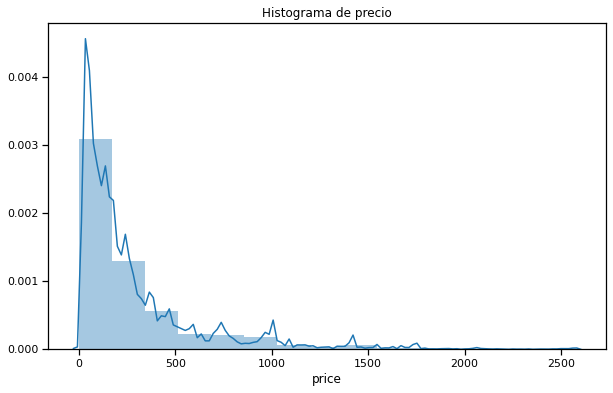

In [10]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.distplot(df['price'],bins=15, hist=True, kde=True)
ax.set_title('Histograma de precio') # están concentrados entre 0 y 250 mas o menos

In [91]:
usuarios = df['user_id']

id_compradores = df[df['event_type'] == 'purchase']['user_id']
comp_unicos = id_compradores.nunique()
comp_porcentaje = (id_compradores.nunique()/usuarios.nunique())*100
print(f'Hay {usuarios.nunique()} usuarios en la página de ecommerce. Solo el {round(comp_porcentaje,2)}% son compradores, es decir {id_compradores.nunique()} usuarios.')

categories = df['category_code'].nunique()
codigos_vendidos = df[df['event_type'] == 'purchase']['category_code']
cod_vendidos_porcentaje = (codigos_vendidos.nunique()/df['category_code'].nunique())*100
print(f'Hay {categories} categorías a vender. El {round(cod_vendidos_porcentaje,2)}% se han vendido aunque sea una vez, es decir {codigos_vendidos.nunique() }.')

productos = df['category_id'].nunique()
categorias_vendidas = df[df['event_type'] == 'purchase']['category_id']
categorias_vendidas.nunique() 
productos_vendidos_porc = (categorias_vendidas.nunique()/df['category_id'].nunique())*100
print(f'Hay {productos} productos a vender. El {round(productos_vendidos_porc,2)}% se han vendido aunque sea una vez, es decir {categorias_vendidas.nunique() }.')

Hay 1028553 usuarios en la página de ecommerce. Solo el 12.09% son compradores, es decir 124354 usuarios.
Hay 126 categorías a vender. El 92.06% se han vendido aunque sea una vez, es decir 116.
Hay 614 productos a vender. El 87.62% se han vendido aunque sea una vez, es decir 538.


## Tratamiento de duplicados

In [33]:
print(f' Hay {df.duplicated().sum()} duplicados en el dataset')
df.drop_duplicates(inplace=True)

 Hay 5990 duplicados en el dataset


## Métodos para tratamiento de datos

In [34]:
# método de para tratamiento de fechas de fechas
def process_event_time(df, time_format='%Y-%m-%d %H:%M:%S UTC'):
    df['event_time'] = pd.to_datetime(df['event_time'], format = time_format)
    df['day_of_week'] = df.event_time.dt.day_name()   
    df['date'] = df.event_time.dt.date
    df['time'] = df.event_time.dt.time
    df = df.drop(columns='event_time') #no lo uso con inplace porque me puede afectar la variable global df 
    return df

In [ ]:
# método para tratamiento de categorías
def prepare_categories(df, levels=2):
    df_categories = df['category_code'].str.split('.',expand=True)
    if len(df_categories.columns) > levels:
        to_remove = df_categories.columns[levels:]
    df_categories.drop(columns=to_remove,inplace=True) #puedo usar el inplace porque no es global, la estoy definiendo acá
    df = pd.concat([df,df_categories],axis=1)
    df = df.drop(columns='category_code')
    df.columns = ['event_type','product_id','category_id','brand','price', 'user_id','user_session', 'day_of_week',
               'date','time','cat_code','category','product']
    return df

In [ ]:
def check_outliers(category, umbral=1.5):
    price_category = df_preprocessed.loc[df_preprocessed['category']==category, 'price']
    Q1 = price_category.quantile(0.25)
    Q3 = price_category.quantile(0.75)
    IQR = Q3 - Q1
    umbral_outlier = IQR * umbral
    valor_absoluto_outliers_superior = (price_category > umbral_outlier).sum()
    valor_absoluto_outliers_inferior = (price_category < umbral_outlier*-1).sum()
    valor_relativo_outliers_superior = valor_absoluto_outliers_superior / len(price_category)
    valor_relativo_outliers_inferior = valor_absoluto_outliers_inferior / len(price_category)
    metricas = {'v_a_s':valor_absoluto_outliers_superior,'v_r_s':valor_relativo_outliers_superior,
                'v_a_i':valor_absoluto_outliers_inferior,'v_r_i':valor_relativo_outliers_inferior}
    return metricas

## Tratamiento de datos

In [ ]:
df_preprocessed = process_event_time(df)

nulos: 
- heatmap(df.isnull()) para ver la distribución por columna
- eliminar los productos gratis 
- eliminar aquellas vistas con category code nulos
- category code nulos restantes, reemplazarlos según el product id, después asignarles una categoría por defecto y ver su frecuencia. Eliminar los no relevantes.


variables:
- dejar solo categorias y productos que representen hasta un 1%
- pasar a datetime los que se necesiten

### Tratamiento de nulos

Category code

In [36]:
df_preprocessed[df_preprocessed.category_code.isna()]['event_type'].value_counts(normalize=True)

view       0.958
purchase   0.030
cart       0.013
Name: event_type, dtype: float64

In [37]:
df_preprocessed[df_preprocessed.category_code.isna()]['event_type'].value_counts()

view        1832785
purchase      56488
cart          24635
Name: event_type, dtype: int64

Como nuestro objetivo es analizar la incidencia entre carrito --> compra, decidimos borrar las vistas que no poseen categoría. 

In [39]:
view_ccode_nan = df_preprocessed.loc[(df_preprocessed['event_type'] == 'view') & (df_preprocessed.category_code.isna())]
df_preprocessed.drop(view_ccode_nan.index, inplace=True)

Para analizar las NaN restantes entre carrito y compra les asignamos valores. 
- Selección por id único (3 primeros n° de product_id) con las no NaN coincidentes
- Selección por id único, pero con el n° por defecto, no con un nombre

Luego verificamos la frecuencia de cada uno para dejar solo los que representen al menos 1% del total.

In [40]:
df_preprocessed['cat_code'] = df_preprocessed['product_id'].astype(str).str[:3]

newdf = df_preprocessed[['cat_code','category_code']].copy()
newdf = newdf.set_index('cat_code')
newdf = newdf.dropna().drop_duplicates()
cat_codes_dict = newdf['category_code'].to_dict()
df_preprocessed['category_code'].fillna(df_preprocessed['cat_code'].map(cat_codes_dict),inplace=True)

df_preprocessed['category_code'].isnull().sum()

71943

In [43]:
df_test = df_preprocessed.copy() # en un df de prueba hacemos la carga de n° para ver la frecuencia
df_test.loc[pd.isna(df_preprocessed["category_code"]), "category_code"] = df_test[pd.isna(df_test["category_code"])]["cat_code"]
df_test['category_code'].value_counts(normalize=True)[:15]

electronics.smartphone             0.404
electronics.clocks                 0.045
electronics.audio.headphone        0.040
electronics.video.tv               0.038
computers.notebook                 0.037
appliances.kitchen.washer          0.030
appliances.kitchen.refrigerators   0.028
appliances.environment.vacuum      0.028
apparel.shoes                      0.024
auto.accessories.player            0.015
computers.desktop                  0.013
apparel.shoes.keds                 0.012
electronics.audio.subwoofer        0.011
electronics.tablet                 0.011
furniture.bedroom.bed              0.010
Name: category_code, dtype: float64

Vemos que en las categorías más frecuentes no hay presente ninguno de estos valores NaN, entonces decidimos borrarlas en nuestro df_preprocessed.

In [51]:
df_preprocessed.drop(df_preprocessed[df_preprocessed['category_code'].isna()].index, inplace=True)

print(f"Quedan {df_preprocessed.shape[0]} entradas en el dataset. Cada tipo de visita representa:\n{df_preprocessed['event_type'].value_counts(normalize=True)}")

Quedan 4173499 entradas en el dataset. Cada tipo de visita representa:
view       0.904
cart       0.051
purchase   0.045
Name: event_type, dtype: float64


En conclusión, eliminamos en un primer momento los datos nulos correspondientes a views ya que representan la mayoría de los nulos y no influyen en nuestro objetivo. Corroborando, vemos que al principio las views representan un 92% de los datos, compras y carrito el 4% cada uno. Luego del analisis y eliminación las views representan 90%, los carritos 5% y las compras 4,5%.

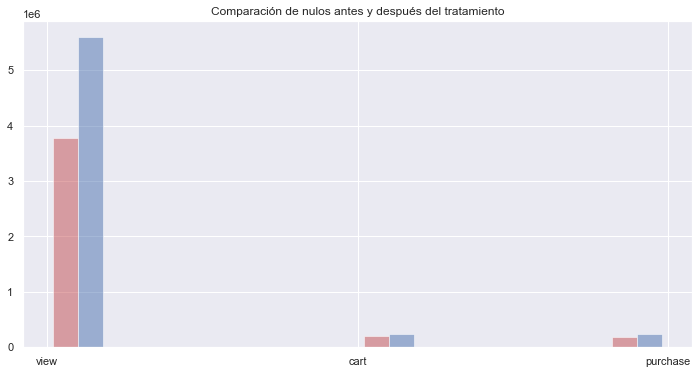

In [63]:
y = df['event_type'].to_numpy()
x = df_preprocessed['event_type'].to_numpy()
plt.figure(figsize=(12,6))
plt.hist([x,y] , color=['r','b'], alpha=0.5)
plt.title('Comparación de nulos antes y después del tratamiento');

In [65]:
preprocesado = pd.Series(df_preprocessed['event_type']).value_counts()
original = pd.Series(df['event_type']).value_counts()

#get the counts as a dataframe
df1=pd.concat([preprocesado,original],axis=1)
df1.columns=['preprocesado','original']

# melt the data frame so it has a "tidy" data format
df1=df1.reset_index().melt(id_vars=['index'])
df1

,index,variable,value
0,view,preprocesado,3772532
1,cart,preprocesado,211929
2,purchase,preprocesado,189038
3,view,original,5605317
4,cart,original,231338
5,purchase,original,241572


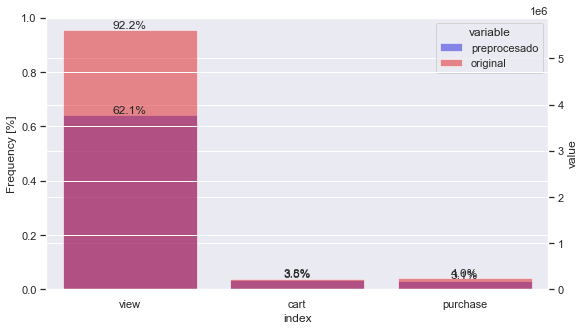

In [67]:
#plot a bar graph and assign variable to hue
ncount = len(df)
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(
    x='index',
    y='value',
    hue='variable',
    data=df1,
    palette=['blue','red'],
    alpha=.5,
    dodge=False)

# Make twin axis
ax2=ax.twinx()

ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')


ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text


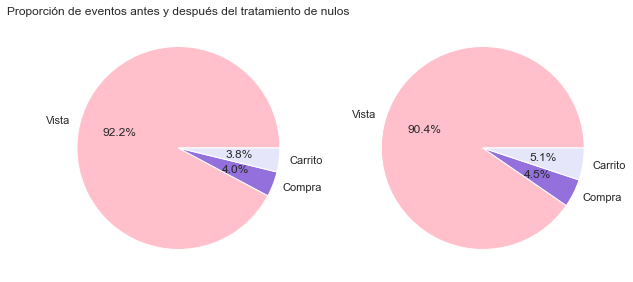

In [92]:
fig, ax =plt.subplots(figsize=(10,10))
antes_tnulos = [92.2, 4.0, 3.8]
mylabels = 'Vista', 'Compra', 'Carrito'
colors = ['pink', 'mediumpurple', 'lavender']

plt.subplot(1,2,1)
plt.pie(antes_tnulos, labels=mylabels, autopct='%1.1f%%', colors=colors)
plt.title('Proporción de eventos antes y después del tratamiento de nulos');
desp_tnulos = [90.4, 4.5, 5.1]
mylabels1 = 'Vista', 'Compra', 'Carrito'
colors = ['pink', 'mediumpurple', 'lavender']

plt.subplot(1,2,2)
plt.pie(desp_tnulos, labels=mylabels1, autopct='%1.1f%%', colors=colors);

### Eliminar outliers de precios

Antes de comenzar, separamos por categoría con sus correspondientes productos. Primero, se corrobora cuales categorías son más frecuentes (representan al menos 1% del total de los datos) y se clasifica a las demás como 'otros', luego, se buscan outliers de cada categoría.

In [71]:
df_preprocessed = prepare_categories(df_preprocessed)
df_preprocessed.head(2)

Eliminación de productos gratis

In [73]:
free_prods = df_preprocessed[df_preprocessed['price']==0] # productos gratis
df_preprocessed.drop(free_prods.index, inplace=True)

Búsqueda de productos frecuentes

In [74]:
df_preprocessed['category'].value_counts(normalize=True)


electronics    0.573
appliances     0.173
computers      0.076
apparel        0.047
furniture      0.039
auto           0.034
construction   0.025
kids           0.017
accessories    0.009
sport          0.005
medicine       0.001
country_yard   0.000
stationery     0.000
Name: category, dtype: float64

In [75]:
cat_frecuentes = df_preprocessed['category'].value_counts(normalize=True)[:8].index.to_list()
cat_frecuentes

['electronics',
 'appliances',
 'computers',
 'apparel',
 'furniture',
 'auto',
 'construction',
 'kids']

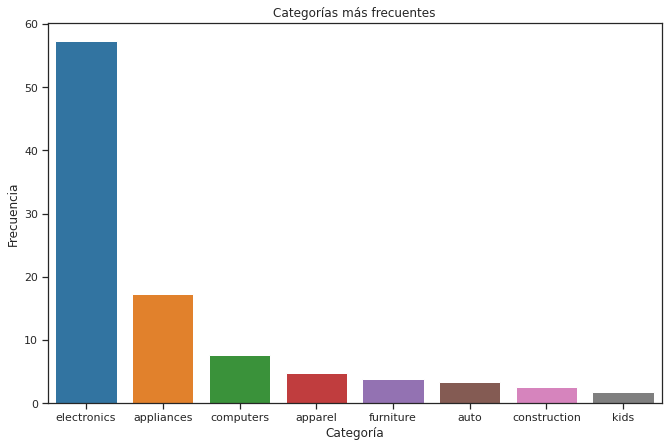

In [59]:
fig,ax = plt.subplots(figsize = (11, 7))
sns.barplot(x=cat_frecuentes, y=df_preprocessed['category'].value_counts(normalize=True)[:8]*100, data=df_preprocessed)
ax.set_title('Categorías más frecuentes')
ax.set(xlabel='Categoría', ylabel='Frecuencia');

In [76]:
df_preprocessed.loc[~(df_preprocessed['category'].isin(cat_frecuentes)),'category'] = 'others'

In [77]:
df_preprocessed['category'].value_counts(normalize=True)

electronics    0.573
appliances     0.173
computers      0.076
apparel        0.047
furniture      0.039
auto           0.034
construction   0.025
kids           0.017
others         0.015
Name: category, dtype: float64

[Text(0, 0.5, 'Frecuencia'), Text(0.5, 0, 'Categoría')]

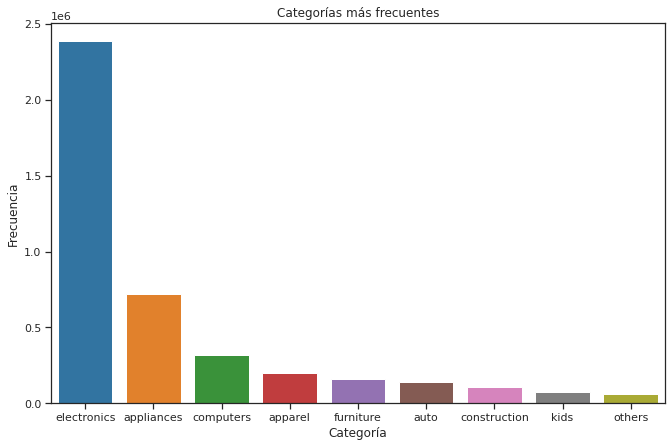

In [62]:
fig,ax = plt.subplots(figsize = (11, 7))
sns.countplot(x='category', order = df_preprocessed['category'].value_counts().index, data=df_preprocessed)
ax.set_title('Categorías más frecuentes')
ax.set(xlabel='Categoría', ylabel='Frecuencia')


In [66]:
check_outliers('electronics')

{'v_a_i': 0, 'v_a_s': 541136, 'v_r_i': 0.0, 'v_r_s': 0.22651701045902328}

In [67]:
price_category = df_preprocessed.loc[df_preprocessed['category']=='electronics', 'price']

In [68]:
price_category.quantile(0.75)

534.38

In [69]:
umbrales = np.array([1,2,3,4,5,6,7,8,9])
umbrales = pd.DataFrame(umbrales)

In [70]:
newdf = df_preprocessed['category'].copy()
newdf = newdf.drop_duplicates()
newdf = newdf.dropna()
newdf.reset_index()

,index,category
0,39054315,electronics
1,24303444,computers
2,27046904,appliances
3,11200334,apparel
4,36883873,construction
5,10457763,furniture
6,28992716,others
7,25974194,kids
8,22255524,auto




## Analisis multi-variado

In [78]:
smartphone = df_preprocessed[(df_preprocessed['product']=='smartphone') & (df_preprocessed['event_type']=='view') ]
smartphone.head(1)

,event_type,product_id,category_id,brand,price,user_id,user_session,day_of_week,date,time,cat_code,category,product
39054315,view,1004767,2053013555631882655,samsung,243.220,564343135,76be743b-f5cd-47a2-82eb-b489597df6ba,Tuesday,2019-10-29,07:06:41,100,electronics,smartphone


In [79]:
smart = df_preprocessed[df_preprocessed['product']=='smartphone']
smart.groupby('day_of_week')['event_type'].value_counts()

day_of_week  event_type
Friday       view          200733
             cart           21355
             purchase       15105
Monday       view          187842
             cart           17908
             purchase       14302
Saturday     view          191774
             cart           19237
             purchase       13802
Sunday       view          197324
             cart           19132
             purchase       14113
Thursday     view          224080
             cart           20791
             purchase       17255
Tuesday      view          229334
             cart           21453
             purchase       17211
Wednesday    view          230086
             cart           21472
             purchase       18110
Name: event_type, dtype: int64

In [81]:
vistas_smartp_porc = (df_preprocessed[(df_preprocessed['event_type']=='view') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size())/len(df_preprocessed[(df_preprocessed['product']=='smartphone')])*100
carrito_smartp_porc = (df_preprocessed[(df_preprocessed['event_type']=='cart') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size())/len(df_preprocessed[(df_preprocessed['product']=='smartphone')])*100
compras_smartp_porc = (df_preprocessed[(df_preprocessed['event_type']=='purchase') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size())/len(df_preprocessed[(df_preprocessed['product']=='smartphone')])*100

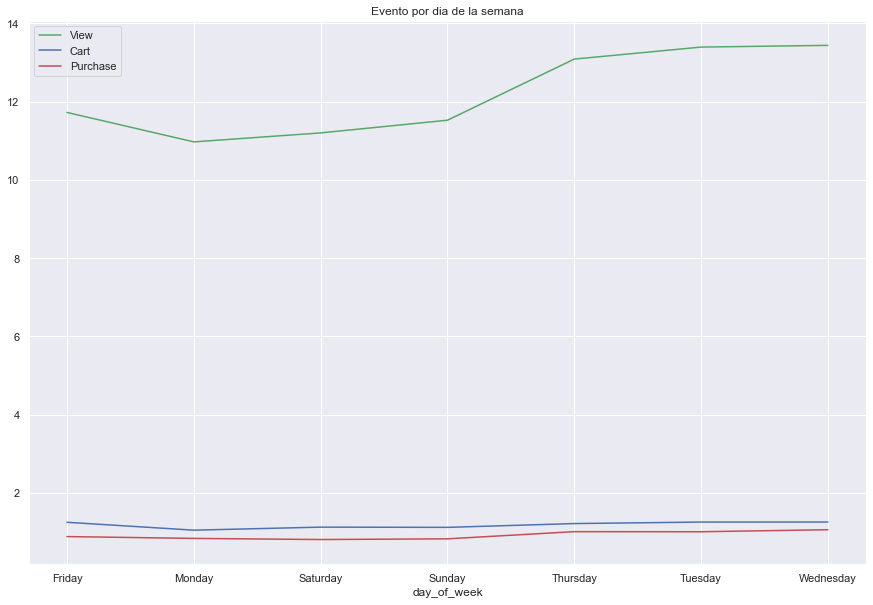

In [82]:
fig,ax=plt.subplots()
vistas_smartp_porc.plot(figsize=(15,10),color='g',label='View')
carrito_smartp_porc.plot(figsize=(15,10),label='Cart')
compras_smartp_porc.plot(figsize=(15,10),color='r',label='Purchase')
plt.title('Evento por dia de la semana')
plt.legend();

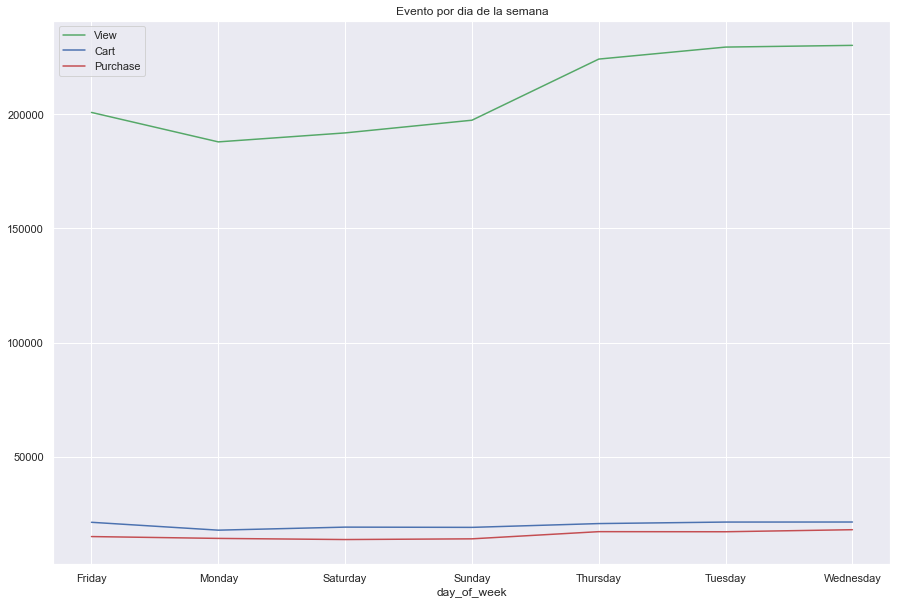

In [83]:
fig,ax=plt.subplots()
df_preprocessed[(df_preprocessed['event_type']=='view') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(15,10),color='g',label='View')
df_preprocessed[(df_preprocessed['event_type']=='cart') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(15,10),label='Cart')
df_preprocessed[(df_preprocessed['event_type']=='purchase') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(15,10),color='r',label='Purchase')
plt.title('Evento por dia de la semana')
plt.legend();

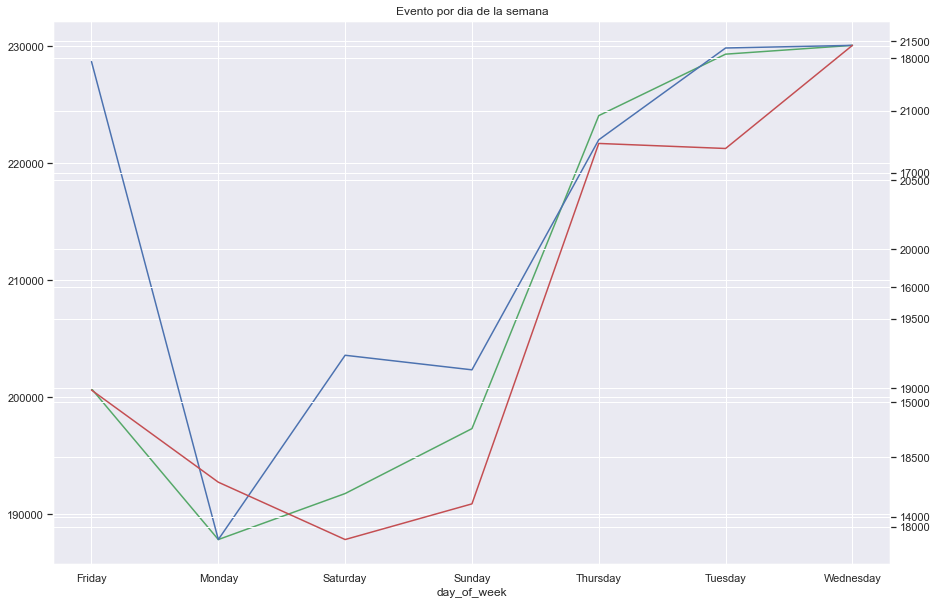

In [84]:
fig,ax=plt.subplots()
df_preprocessed[(df_preprocessed['event_type']=='view') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(15,10),ax=ax,color='g',label='View')
ax2 = ax.twinx()
df_preprocessed[(df_preprocessed['event_type']=='cart') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(15,10),ax=ax2,label='Cart')
ax3 = ax.twinx()
df_preprocessed[(df_preprocessed['event_type']=='purchase') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(15,10),ax=ax3,color='r',label='Purchase')
plt.title('Evento por dia de la semana');


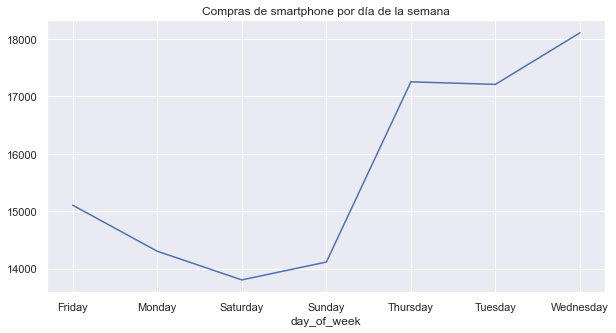

In [86]:
df_preprocessed[(df_preprocessed['event_type']=='purchase') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(10,5))
plt.title('Compras de smartphone por día de la semana');

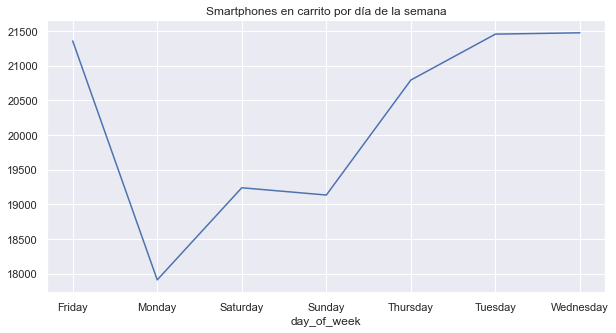

In [87]:
df_preprocessed[(df_preprocessed['event_type']=='cart') & (df_preprocessed['product']=='smartphone')].groupby('day_of_week').size().plot(figsize=(10,5))
plt.title('Smartphones en carrito por día de la semana');